In [106]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch as th
import cmasher as cmr
from tqdm import tqdm
import copy
from functorch import hessian
import os
import seaborn

os.makedirs("img", exist_ok=True)
seaborn.set_style('whitegrid')
cmap = cmr.get_sub_cmap('plasma', 0.01, 1.)

import matplotlib as mpl

mpl.rcParams["axes.titlesize"] = 14.
mpl.rcParams["axes.labelsize"] = 12.
mpl.rcParams["font.size"] = 12.
mpl.rcParams["axes.titleweight"] = "bold"
mpl.rcParams["axes.labelweight"] = "normal"
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.serif'] = ['cm']
mpl.rcParams['font.family'] = "serif"
mpl.rcParams['font.serif'] = ['CMU']

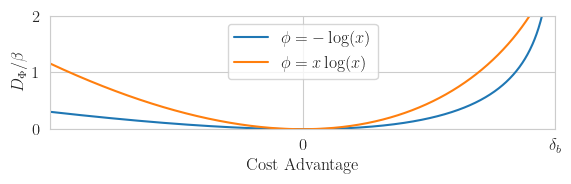

In [122]:
limit = 3

def d_c_barrier(x):
    return (limit-x)/limit - np.log((limit-x)/limit) - 1

def d_c_entropy(x):
    return x - (limit-x)*np.log(limit/(limit-x))

_, ax = plt.subplots(1, 1, figsize=(6, 2))

x = np.linspace(-limit, limit-1e-6, 1000)
ax.plot(x, d_c_barrier(x), label=r"$\phi=-\log(x)$")
ax.plot(x, d_c_entropy(x), label=r"$\phi=x\log(x)$")
ax.set_xlim(-limit, limit)
ax.set_ylim(0, 2)

ax.set_xticks([-limit, 0., limit])
ax.set_xticklabels(["", "0", r"$\delta_b$"])

ax.set_xlabel(r"Cost Advantage")
ax.set_ylabel(r"$D_\Phi/\beta$")

ax.legend()

plt.tight_layout()

plt.savefig("img/div_advantage.pdf")

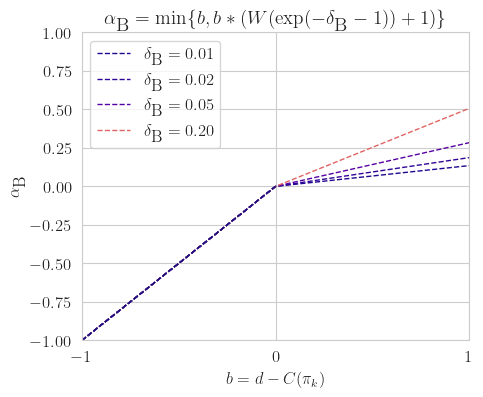

In [120]:
from scipy.special import lambertw
import math

_, axs = plt.subplots(1, 1, figsize=(5, 4))

def budget_function(b, alpha):
    x = b*(lambertw(-np.exp(-alpha-1))+1)
    return np.minimum(b, x)

def budget_function_2(b, alpha):
    return np.sqrt(2*b*alpha)

x = np.linspace(-1, 1, 500)
for d in [0.01, 0.02, 0.050, 0.2]:
    axs.plot(x, budget_function(x, d), label=r"$\delta_\textup{B}={%.2f}$" % d, color=cmr.get_sub_cmap('plasma', 0, 1.)(d*3), linestyle="dashed", linewidth=1)
    axs.plot(np.linspace(-1, 0, 250), np.linspace(-1, 0, 250), color=cmr.get_sub_cmap('plasma', 0, 1.)(0), linestyle="dashed", linewidth=1)
    #axs.plot(x, budget_function_2(x, alpha), label=r"$B_\alpha(s)$ ($\alpha = %.3f$)" % alpha, color=cmap(alpha), linestyle="solid", linewidth=1)
#x = np.linspace(-1, 1, 1000)
#axs.plot(x, x, label=r"$y=x$", linestyle="solid", color="black", linewidth=1)

axs.legend()
axs.set_xlim(-1, 1)
axs.set_ylim(-1, 1)
axs.set_xlabel(r"$b=d-C(\pi_k)$")
axs.set_ylabel(r"$\alpha_\textup{B}$")
axs.set_title(r"$\alpha_\textup{B} =  \min\{b, b*(W(\exp(-\delta_\textup{B}-1))+1)\}$")

axs.set_xticks([-1, 0, 
1])
plt.savefig("img/budget_function.pdf")

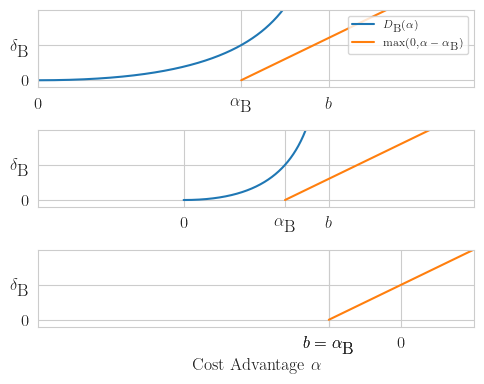

In [115]:
limit = 3
d = 0.5

def d_c_barrier(x):
    return np.log(limit/(limit-x)) - x/limit

def relu(x, a):
    return np.maximum(0, x-a)

_, axs = plt.subplots(3, 1, figsize=(5, 4))

for ax, limit in zip(axs, [2, 1, -0.5]):
    alpha = min(limit, budget_function(limit, d).real)

    if limit > 0:
        x = np.linspace(0, limit-1e-6, 1000)
        ax.plot(x, d_c_barrier(x), label=r"$D_\textup{B}(\alpha)$")
    else:
        x = np.linspace(0, 0+1e-6, 1000)
        ax.plot(x, np.zeros_like(x), label=r"$D_\textup{B}(\alpha)$")

    x = np.linspace(alpha, limit+1, 1000)
    ax.plot(x, relu(x, alpha), label=r"max$(0, \alpha-\alpha_\textup{B})$")

    ax.set_xlim(-2+limit, limit+1)
    ax.set_ylim(-0.1, d*2)

    if limit > 0:
        ax.set_xticks([0., alpha, limit])
        ax.set_xticklabels(["0", r"$\alpha_\textup{B}$", r"$b$"])
    else:
        ax.set_xticks([0., alpha, limit])
        ax.set_xticklabels(["0", r"$\alpha_\textup{B}$", r"$b=\alpha_\textup{B}$"])

    ax.set_yticks([0, d])
    ax.set_yticklabels([0, r"$\delta_\textup{B}$"])

axs[-1].set_xlabel(r"Cost Advantage $\alpha$")
    #ax.set_ylabel(r"")

axs[0].legend(fontsize=8, loc="upper right")

plt.tight_layout()

plt.savefig("img/moving_barrier.pdf")